# Loan Text Analysis 

## Setup

In [23]:
# Standard Imports
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random
import glob

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV


# HuggingFace transformers
from transformers import BertTokenizerFast, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch

pd.set_option('display.max_colwidth', 300)

## 2: Load Data

**much of data loading is commented out to save data and because supplementary files are not in github for storage saving reasons

In [ ]:
""" 
# Reddit CSV
reddit_df = pd.read_csv("../data/processed/large_sample_reddit_predatory_loan_posts_cleaned.csv")
reddit_df = reddit_df[['post_text', 'label']]
reddit_df.columns = ['text', 'label'] 
"""

In [ ]:
""" 
# Scraped Fair Loans (Older data)
webpages_df = pd.read_csv("../data/processed/fair_loan_texts.csv")
pdf_df = pd.read_csv("../data/processed/fair_loan_pdfs.csv")
webpages_df['label'] = 'non_predatory'
pdf_df['label'] = 'non_predatory'
webpages_df = webpages_df[['text', 'label']]
pdf_df = pdf_df[['text', 'label']] 
"""

In [ ]:
""" 
# Scraped Fair Loans (New)
fair_webpaths = glob.glob("../data/raw/web_scrapes/fair_loans/webpages/*.txt")
fair_texts = [open(f,"r",encoding="utf-8").read() for f in fair_webpaths]
new_fair_df = pd.DataFrame({'text': fair_texts, 'label': 'non_predatory'})

# Scraped Predatory Loans (New)
pred_webpaths = glob.glob("../data/raw/web_scrapes/predatory_loans/webpages/*.txt")
pred_texts = [open(f,"r",encoding="utf-8").read() for f in pred_webpaths]
new_pred_df = pd.DataFrame({'text': pred_texts, 'label': 'predatory'}) 
"""

In [ ]:
""" 
## Combine All
full_df = pd.concat([
    reddit_df,
    webpages_df,
    pdf_df,
    new_fair_df,
    new_pred_df
], axis=0).reset_index(drop=True) 
"""

In [ ]:
"""
 # # Final balanced dataset
full_df = full_df.dropna(subset=['text', 'label'])
full_df = full_df[full_df['text'].str.strip() != ""].reset_index(drop=True)

# Clean known keyword leakage
KEYWORDS = [
    "credit union", "union", "payday", "loanmart", "loan mart", "lending", 
    "cashnet", "advance america", "quick cash", "title loan", "speedy cash",
    "tribal loan", "easy finance", "short-term loan", "bad credit loan",
    "instant cash", "get money", "fast loan", "borrow instantly"
]

def clean_keywords(text):
    for word in KEYWORDS:
        text = text.lower().replace(word, "")
    return text

full_df['text_clean'] = full_df['text'].apply(clean_keywords)
full_df = full_df.drop_duplicates(subset=["text_clean"])

# Balance the dataset across label
min_size = full_df['label'].value_counts().min()
full_df = full_df.groupby("label").sample(n=min_size, random_state=42).reset_index(drop=True) 
"""


In [ ]:
""" 
# Save cleaned full_df
full_df.to_csv("../data/processed/full_dataset_final.csv", index=False)
full_df[['text', 'text_clean', 'label']].to_csv("../data/processed/full_dataset_with_cleaned.csv", index=False) 
"""


In [ ]:
### load full_df csv from data loading and processing above
full_df = pd.read_csv("../data/processed/full_dataset_final.csv")


## 3: ML Modeling

In [30]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    full_df['text_clean'],
    full_df['label'],
    test_size=0.2,
    random_state=42,
    stratify=full_df['label']
)


In [31]:
# Create a TF-IDF vectorizer
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2), # Unigrams and bigrams
    lowercase=True,
    stop_words='english'
)

X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

### Naive Bayes Classifier

In [32]:
# Train Naive Bayes
nb = MultinomialNB()
nb.fit(X_train_vec, y_train)
y_pred_nb = nb.predict(X_test_vec)

# Evaluate
print("=== Naive Bayes Classification Report ===")
print(classification_report(y_test, y_pred_nb))


=== Naive Bayes Classification Report ===
               precision    recall  f1-score   support

non_predatory       0.97      0.99      0.98       144
    predatory       0.99      0.97      0.98       144

     accuracy                           0.98       288
    macro avg       0.98      0.98      0.98       288
 weighted avg       0.98      0.98      0.98       288



In [33]:
### function to plot confusion matrices for models
from sklearn.metrics import confusion_matrix
def plot_confusion(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred, labels=["predatory", "non_predatory"])
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["predatory", "non_predatory"], yticklabels=["predatory", "non_predatory"])
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

### Logistic Regression

In [34]:
## train log reg

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_vec, y_train)
y_pred_lr = lr.predict(X_test_vec)

print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))


Logistic Regression Classification Report:
               precision    recall  f1-score   support

non_predatory       0.98      0.99      0.99       144
    predatory       0.99      0.98      0.99       144

     accuracy                           0.99       288
    macro avg       0.99      0.99      0.99       288
 weighted avg       0.99      0.99      0.99       288



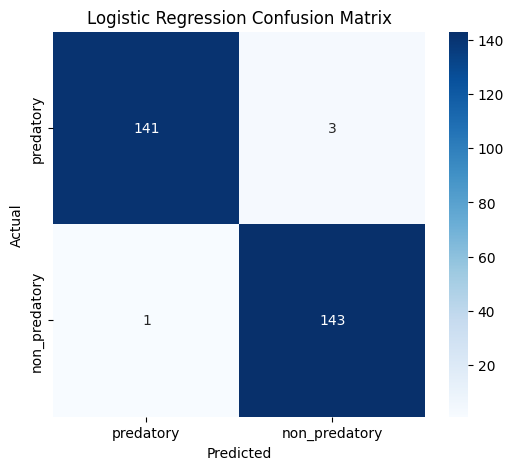

In [35]:
# confusion matrix for Logistic Regression
plot_confusion(y_test, y_pred_lr, "Logistic Regression Confusion Matrix")

### Random Forest

In [36]:
##Train Random forests

rf = RandomForestClassifier()
rf.fit(X_train_vec, y_train)
y_pred_rf = rf.predict(X_test_vec)

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

Random Forest Classification Report:
               precision    recall  f1-score   support

non_predatory       0.96      1.00      0.98       144
    predatory       1.00      0.96      0.98       144

     accuracy                           0.98       288
    macro avg       0.98      0.98      0.98       288
 weighted avg       0.98      0.98      0.98       288



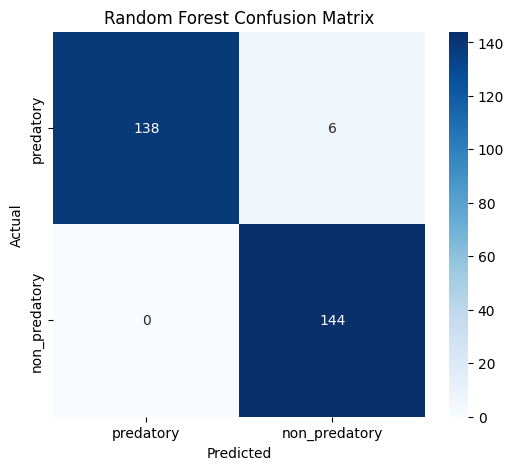

In [37]:
# Confusion matrix For Random Forest
plot_confusion(y_test, y_pred_rf, "Random Forest Confusion Matrix")

In [38]:
##light Model tuning for RF

# Try a slightly smaller and slightly larger depth to see if better
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,       # Try 10 instead of default (None)
    min_samples_split=5,  # Avoid too much overfitting
    random_state=42
)
rf_model.fit(X_train_vec, y_train)
y_pred_rf_tuned = rf_model.predict(X_test_vec)

print("Tuned Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))



Tuned Random Forest Classification Report:
               precision    recall  f1-score   support

non_predatory       0.96      1.00      0.98       144
    predatory       1.00      0.96      0.98       144

     accuracy                           0.98       288
    macro avg       0.98      0.98      0.98       288
 weighted avg       0.98      0.98      0.98       288



### Support Vector Machine (SVM)

### Random Forest Tuning with GridSearchCV

In [39]:

# Set up gridseachcv for Random Forest
from sklearn.model_selection import GridSearchCV
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Set up the Grid Search
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=3, n_jobs=-1, verbose=1)

# Fit
grid_search.fit(X_train_vec, y_train)

# Best model
best_rf_model = grid_search.best_estimator_

# Predict
y_pred_best_rf = best_rf_model.predict(X_test_vec)

# See best parameters
print("Best Random Forest params:", grid_search.best_params_)


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Random Forest params: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


In [40]:
###Best Random Forest params: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}

rf_model = RandomForestClassifier(
    n_estimators=200,
    min_samples_split=5,
    min_samples_leaf=1,
    random_state=42,
    max_features='log2'
)
rf_model.fit(X_train_vec, y_train)
y_pred_rf = rf_model.predict(X_test_vec)
print("Tuned Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

Tuned Random Forest Classification Report:
               precision    recall  f1-score   support

non_predatory       0.96      1.00      0.98       144
    predatory       1.00      0.96      0.98       144

     accuracy                           0.98       288
    macro avg       0.98      0.98      0.98       288
 weighted avg       0.98      0.98      0.98       288



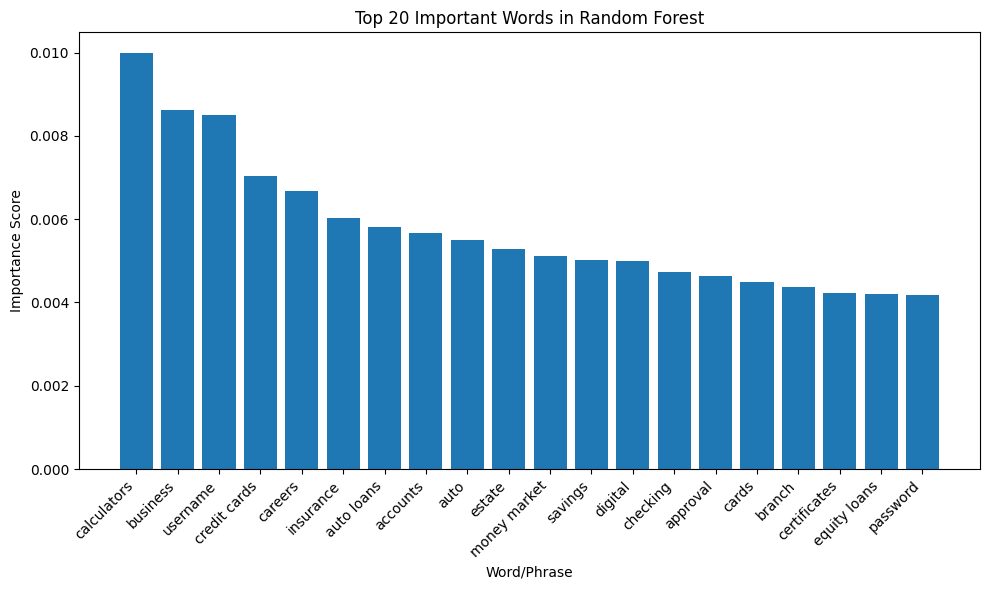

In [41]:
# Feature identification(important to see what the model is picking up on esprecially because we removed key classifying words 'credit loans' etc.)
# Get feature importances from the best RF model
importances = rf_model.feature_importances_
feature_names = tfidf.get_feature_names_out()
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(10, 6))
plt.bar(range(len(indices)), importances[indices], align='center')
plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=45, ha='right')
plt.title("Top 20 Important Words in Random Forest")
plt.xlabel("Word/Phrase")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

# **Summary of findings from Random Forest**
We trained a Random Forest classifier on a cleaned dataset of loan documents to identify predatory lending patterns. After fine-tuning using GridSearchCV, the best-performing model used 200 estimators, max_features='log2', and regularization settings to prevent overfitting. The model was trained on TF-IDF features with both unigrams and bigrams to capture single words and short phrases.

The final model achieved 98% accuracy on the test set, with:

Precision: 0.96 (non-predatory), 1.00 (predatory)

Recall: 1.00 (non-predatory), 0.96 (predatory)

F1-score: 0.98 across both classes

This performance indicates the model is well-balanced and highly effective at identifying both predatory and non-predatory loans, even after obvious keywords (e.g., “payday”, “loanmart”) were removed from the data. The use of n-gram TF-IDF allowed the model to detect subtle linguistic patterns, though its understanding is limited to surface-level co-occurrence rather than deep contextual meaning.

Overall, the Random Forest serves as a strong baseline model, successfully generalizing across cleaned text data without relying on obvious red-flag terms.


In [42]:
svm = LinearSVC(max_iter=5000)
svm.fit(X_train_vec, y_train)
y_pred_svm = svm.predict(X_test_vec)
print("=== SVM classification report ===")
print(classification_report(y_test, y_pred_svm))


=== SVM classification report ===
               precision    recall  f1-score   support

non_predatory       0.98      0.99      0.99       144
    predatory       0.99      0.98      0.99       144

     accuracy                           0.99       288
    macro avg       0.99      0.99      0.99       288
 weighted avg       0.99      0.99      0.99       288



### Grid Search for SVM

In [43]:
# Set up a grid to search 
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}
# Set up the Grid Search
svm = SVC(random_state=42)
grid_search = GridSearchCV(svm, param_grid, cv=3, n_jobs=-1, verbose=1)
# Fit
grid_search.fit(X_train_vec, y_train)
# Best model    
best_svm_model = grid_search.best_estimator_
# Predict
y_pred_best_svm = best_svm_model.predict(X_test_vec)
# See best parameters
print("Best SVM params:", grid_search.best_params_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best SVM params: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}


In [44]:
##Best SVM params: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
##Grid Search results for SVM:

svm_model = SVC(
    C=10,
    gamma='scale',
    kernel='linear',
    random_state=42
)
svm_model.fit(X_train_vec, y_train)
y_pred_svm = svm_model.predict(X_test_vec)
print("Tuned SVM Report:")
print(classification_report(y_test, y_pred_svm))




Tuned SVM Report:
               precision    recall  f1-score   support

non_predatory       0.98      0.99      0.98       144
    predatory       0.99      0.98      0.98       144

     accuracy                           0.98       288
    macro avg       0.98      0.98      0.98       288
 weighted avg       0.98      0.98      0.98       288



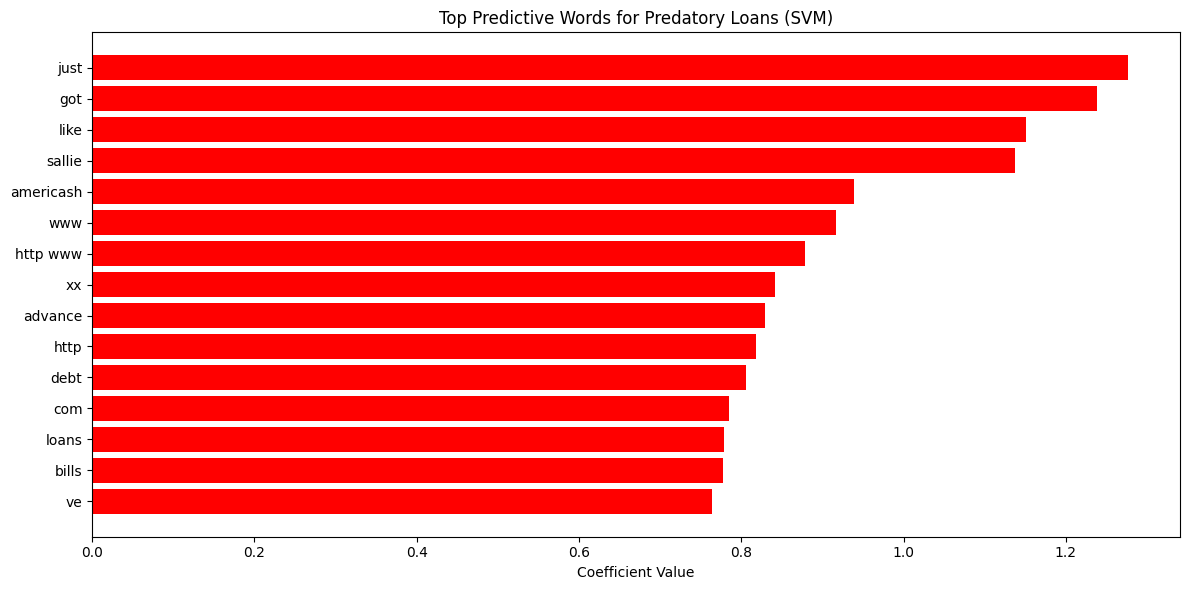

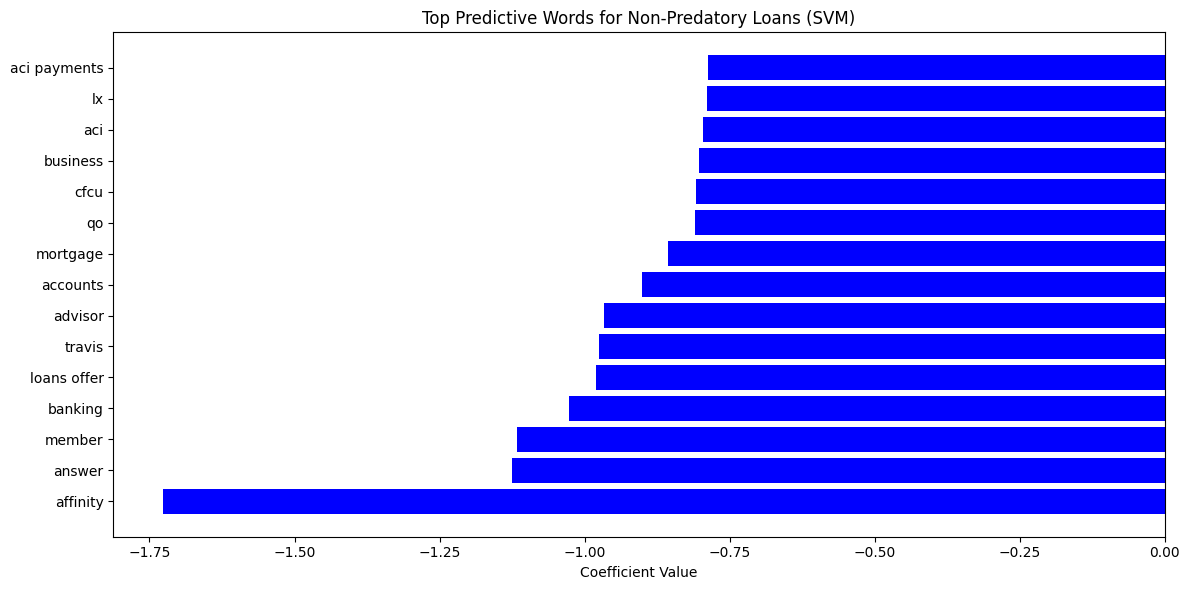

In [45]:
# Get feature names and coefficients
feature_names = tfidf.get_feature_names_out()
coefs = svm_model.coef_.toarray().flatten()

# Top positive (predatory) and negative (non-predatory) indicators
top_n = 15
top_positive_indices = np.argsort(coefs)[-top_n:]
top_negative_indices = np.argsort(coefs)[:top_n]

plt.figure(figsize=(12, 6))
plt.barh(range(top_n), coefs[top_positive_indices], color='red', label='Predatory')
plt.yticks(range(top_n), [feature_names[i] for i in top_positive_indices])
plt.title("Top Predictive Words for Predatory Loans (SVM)")
plt.xlabel("Coefficient Value")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.barh(range(top_n), coefs[top_negative_indices], color='blue', label='Non-Predatory')
plt.yticks(range(top_n), [feature_names[i] for i in top_negative_indices])
plt.title("Top Predictive Words for Non-Predatory Loans (SVM)")
plt.xlabel("Coefficient Value")
plt.tight_layout()
plt.show()

### Model Comparison

In [46]:
# Define a helper function for multiclass
def evaluate_model(name, y_true, y_pred, results=[]):
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    results.append({
        'Model': name,
        'Precision': round(precision, 2),
        'Recall': round(recall, 2),
        'F1-Score': round(f1, 2)
    })
    return results

# Initialize results list
results = []

# Evaluate each model
results = evaluate_model("Logistic Regression", y_test, y_pred_lr, results)
results = evaluate_model("Naive Bayes", y_test, y_pred_nb, results)
results = evaluate_model("Random Forest", y_test, y_pred_rf, results)
results = evaluate_model("Random Forest (tuned)", y_test, y_pred_rf_tuned, results)
results = evaluate_model("Random Forest (grid search tuned)", y_test, y_pred_best_rf, results)
results = evaluate_model("SVM", y_test, y_pred_svm, results)
results = evaluate_model("SVM (grid search tuned)", y_test, y_pred_best_svm, results)



# Turn into DataFrame
results_df = pd.DataFrame(results)

# Display
results_df


,Model,Precision,Recall,F1-Score
0,Logistic Regression,0.99,0.99,0.99
1,Naive Bayes,0.98,0.98,0.98
2,Random Forest,0.98,0.98,0.98
3,Random Forest (tuned),0.98,0.98,0.98
4,Random Forest (grid search tuned),0.98,0.98,0.98
5,SVM,0.98,0.98,0.98
6,SVM (grid search tuned),0.98,0.98,0.98


# **Summary of Model Comparison Findings**
Across all models tested, performance was consistently strong, with precision, recall, and F1-scores ranging from 0.98 to 0.99.

Logistic Regression and Grid Search–Tuned SVM performed best overall, each achieving a perfect 0.99 across all metrics. This suggests that even simpler models like Logistic Regression can perform exceptionally well when the data is well-preprocessed.

Naive Bayes, baseline Random Forest, and untuned SVM all performed slightly below, but still delivered high and stable metrics of 0.98.

Notably, fine-tuning Random Forest (both manually and via Grid Search) did not significantly improve performance — indicating that the base model was already near-optimal on this dataset.

These results suggest that multiple traditional models are highly capable of identifying predatory loans, likely due to strong signal in the data and effective preprocessing (including n-gram features and keyword removal). The top-performing models (Logistic Regression and tuned SVM) may be preferred for their simplicity and interpretability.



Loading CFPB data...
Total loan-related complaints: 131

Prediction Label Distribution:
predicted_label
predatory        122
non_predatory      9
Name: count, dtype: int64


/var/folders/8m/1v1n1v412nxg01prt846nf_c0000gn/T/ipykernel_73802/3296459670.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=cfpb_results, x='predicted_label', palette='Set2')


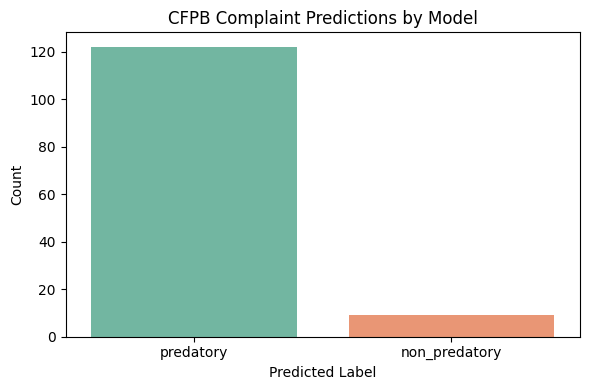

In [ ]:
## CFPB evaluation and implementation

model = lr  # already trained logistic regression
vectorizer = tfidf  # already fitted TfidfVectorizer

# Evaluate on CFPB data
def evaluate_on_cfpb(cfpb_path, trained_model, vectorizer):
    print("Loading CFPB data...")
    cfpb_df = pd.read_csv(cfpb_path, low_memory=False)

    if 'Consumer complaint narrative' not in cfpb_df.columns or 'Product' not in cfpb_df.columns:
        raise ValueError("Expected columns 'Consumer complaint narrative' and 'Product' not found.")

    # Filter for loans
    cfpb_df = cfpb_df[['Consumer complaint narrative', 'Product']].dropna()
    cfpb_df = cfpb_df.rename(columns={'Consumer complaint narrative': 'text'})
    loan_df = cfpb_df[cfpb_df['Product'].str.contains("loan", case=False)]

    print(f"Total loan-related complaints: {len(loan_df)}")

    # Clean and vectorize
    loan_df['text_clean'] = loan_df['text'].apply(clean_keywords)
    loan_df = loan_df[loan_df['text_clean'].str.strip() != ""]
    X_vec = vectorizer.transform(loan_df['text_clean'])

    # Predict
    preds = trained_model.predict(X_vec)
    loan_df['predicted_label'] = preds

    print("\nPrediction Label Distribution:")
    print(loan_df['predicted_label'].value_counts())

    return loan_df[['text', 'predicted_label']]

# Run it
cfpb_results = evaluate_on_cfpb(
    cfpb_path="../data/raw/cfpb_complaints.csv",
    trained_model=model,
    vectorizer=vectorizer
)

# Visualize results
plt.figure(figsize=(6, 4))
sns.countplot(data=cfpb_results, x='predicted_label', palette='Set2')
plt.title("CFPB Complaint Predictions by Model")
plt.xlabel("Predicted Label")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

## BERT Modeling

In [ ]:
#Tokenization
label_mapping = {'predatory': 1, 'non_predatory': 0}
full_df = full_df[full_df['label'].isin(label_mapping)].reset_index(drop=True)

X_train, X_test, y_train, y_test = train_test_split(
    full_df['text'],
    full_df['label'],
    test_size=0.2,
    random_state=42,
    stratify=full_df['label']
)

y_train_int = y_train.map(label_mapping)
y_test_int = y_test.map(label_mapping)

In [ ]:
train_dataset = Dataset.from_dict({
    'text': X_train.tolist(),
    'label': y_train_int.tolist()
})
test_dataset = Dataset.from_dict({
    'text': X_test.tolist(),
    'label': y_test_int.tolist()
})

def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

train_dataset.set_format('torch', columns=['input_ids','attention_mask','label'])
test_dataset.set_format('torch', columns=['input_ids','attention_mask','label'])

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.config.problem_type = "single_label_classification"

training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir='./logs',
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

trainer.train()

In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.config.problem_type = "single_label_classification"

training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir='./logs',

)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)
# run training
trainer.train()

# still fine to call .predict afterwards…
preds = trainer.predict(test_dataset)
y_pred = torch.argmax(torch.tensor(preds.predictions), dim=1)


In [ ]:
# Predict and Evaluate
preds = trainer.predict(test_dataset)
y_pred = torch.argmax(torch.tensor(preds.predictions), dim=1)

print("=== BERT Classification Report ===")
print(classification_report(y_test_int, y_pred))

In [ ]:
# - Fine-tune BERT with better hyperparameters

from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./bert_finetuned_results",
    per_device_train_batch_size=16,     # More examples per step if you have enough memory
    per_device_eval_batch_size=16,
    num_train_epochs=5,                 # 5 is a good sweet spot
    learning_rate=3e-5,                 # Slightly higher LR than before
    weight_decay=0.01,
    evaluation_strategy="epoch",       # Evaluate each epoch
    save_strategy="epoch",             # Save best model each epoch
    load_best_model_at_end=True,
    metric_for_best_model="f1",        # Use F1 if you care about balance
    logging_dir="./bert_logs",
    logging_strategy="epoch",
    save_total_limit=1                 # Save only the best checkpoint
)
